# Corrección Wrapper Grupo 27
Se corrigió el problema reportado vía mail, donde se observaba el siguiente error, concerniente a números de atributos inconsistentes: https://nam10.safelinks.protection.outlook.com/GetUrlReputation

El problema fue que se definió en modelo del wrapper con una extracción de LBP de 4x4, pero a la hora de cargar el modelo, se usó erroneamente LBP de 1x1, razón que explica la inconsistencia entre el número de atributos. Pedimos disculpas por el inconveniente, y agradecemos la comprensión.

**Nota 1**: La librería "mahotas" tiene dificultades para ser descargada. Hay que ejecutar la celda, reiniciar el runtime, y ejecutar nuevamante. Disculpa por las molestias.

**Nota 2**: Las accuracies de los modelos en el wrapper sistemáticamente son un poco menores que las accuracies de la demo (que son las que reportamos en el informe). No logramos identificar por qué pasa esto, pero tiene relación con procesar las imágenes y usarlas directamente (caso wrapper, peor desempeño), o importarlas procesadas desde un link (caso demo, mejores resultados).

# Declaraciones y Definiciones

## Carga de Datos Necesarios

Cargamos todas las librerias, tanto externas como internas, que necesitaremos junto con las variables globales que tambien se usaran

### Librerias

In [1]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 261 (delta 152), reused 177 (delta 74), pack-reused 0
Receiving objects: 100% (261/261), 68.46 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43704 sha256=f53a22dd90040f36c004acc431b585427d5b248ac9e43b05c0ef1d3ff4e006a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pl9xqx90/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [1]:
!pip install numpy --upgrade
!pip install mahotas

In [2]:
from   balu3.fx.chr    import lbp, gabor
from   balu3.cl.basics import ClassifierKNN
from   balu3.fs.sel    import clean
from   balu3.ft.norm   import minmax

from sklearn.decomposition         import TruncatedSVD, PCA
from sklearn.preprocessing         import StandardScaler
from sklearn.feature_selection     import SequentialFeatureSelector, SelectKBest, f_regression
from sklearn.neighbors             import NearestCentroid, KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.naive_bayes           import GaussianNB
from sklearn.neural_network        import MLPClassifier
from sklearn.svm                   import SVC
from sklearn.ensemble              import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection       import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection       import cross_val_score, StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics               import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline              import Pipeline


import os
import cv2
import gdown
import pickle
import subprocess
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.auto import tqdm
from random import shuffle, randint

from skimage.color                 import rgb2gray
from skimage.transform             import warp_polar
from skimage.feature               import greycomatrix, greycoprops, daisy

from scipy.stats                   import uniform, randint

import mahotas

### Funciones varias
Importación, procesamiento y extractores de características

In [3]:
def download_dataset(dataset_url) -> str:
    downloaded_file_name = ''
    result = subprocess.run(['wget', dataset_url], capture_output=True, text=True)
    for char in result.stderr.split('\n'):
        if char.find('Saving to:') != -1:
            downloaded_file_name = char.split(' ')[-1].replace('‘', '').replace('’', '')
    if downloaded_file_name == '':
        print('File name is empty. Possible error in download method')
        return ''
    print(f'Folder {downloaded_file_name} Downloaded!')
    subprocess.run(['unzip', downloaded_file_name], capture_output=True, text=True)
    print(f'Folder {downloaded_file_name} Unziped!')
    folder_name = downloaded_file_name.split('.zip')[0]
    return folder_name

In [4]:
def iris_polar_warp(img, rightcrop=True, rgb=True):
  """
  Transform segmented image of iris into square
  Input:
    img: numpy.array 2D (grayscale) or 3D (rgb, hsv)
  Output:
    transformed: numpy.array
  """
  if not rgb:
    transformed = warp_polar(img, scaling='linear', channel_axis=None)
    if rightcrop:
      transformed = transformed[:,:266]
  else:
    transformed = warp_polar(img, scaling='linear', channel_axis=2)
    if rightcrop:
      transformed = transformed[:,:266, :]
  return transformed

def imgs_process(dataset_to_process, rightcrop=True, rgb=True) -> list:
    # Completar alumnos
    # For students to complete
    processed_imgs = []
    for img in tqdm(dataset_to_process):
        clean_img = 255 * iris_polar_warp(img, rightcrop=rightcrop, rgb=rgb)
        processed_imgs.append(clean_img)
    return np.array(processed_imgs)

def feature_process(dataset_to_process, extracting_methods_pairs) -> np.ndarray:
    # Completar alumnos
    # Lo que retorna lo guardan dentro del atributo de la clase
    X = []
    total_elements = len(dataset_to_process['rgb'])

    # Add: tqdm
    for (rgb_val, gray_val) in tqdm(zip(dataset_to_process['rgb'], dataset_to_process['gray']), total=total_elements):
        img_X = []
        for extracting_methods_pair in extracting_methods_pairs:
            meth, meth_kwargs, is_rgb = extracting_methods_pair
            if is_rgb:
              X_red = meth(rgb_val[:,:,0], **meth_kwargs)
              X_green = meth(rgb_val[:,:,1], **meth_kwargs)
              X_blue = meth(rgb_val[:,:,2], **meth_kwargs)

              img_X.extend(
                  list(np.concatenate((X_red, X_green, X_blue)))
              )
            else:
              img_X.extend(list(meth(gray_val, **meth_kwargs)))

        X.append(img_X)
    X_array = np.array(X)
    return X_array

def features_select_trans(self) -> np.ndarray:
    # Completar alumnos
    return np.array([])

In [5]:
# def load_images(self, dataset_to_fill, dataset_name) -> map:
def load_images(dataset_name, rgb:bool = True) -> tuple[list, list]:
    '''
    Input: dataset_name -> Name of the file containing the images
    Output: [dataset, y]-> A dataset consisting of images and corresponding
    ground truth, which includes the classes.
    '''
    if not os.path.exists(dataset_name):
        print(f"Folder '{dataset_name}' does not exist.")
        return ([], [])
    imread_flag = cv2.IMREAD_COLOR if rgb else cv2.IMREAD_GRAYSCALE
    files = os.listdir(dataset_name)
    sorted_files = sorted(files)
    print('Creating Dataset and Ground Truth')
    dataset_to_fill = []
    y = []
    print(f'Loading {len(sorted_files)} images to Dataset')
    for file_name in sorted_files:
        # Check if the path represents a file
        file_path = os.path.join(dataset_name, file_name)
        if os.path.isfile(file_path):
            img = cv2.imread(f'{dataset_name}/{file_name}', imread_flag)
            dataset_to_fill.append(img)
            img_class = file_name.split('_')[0][-2:]
            y.append(int(img_class))

    print(f'Dataset filled with a total of {len(dataset_to_fill)} images')
    return (dataset_to_fill, y)


In [6]:
def get_features_tas(images, class_size:int, n_clases:int = 90, RGB:bool = False):

  Mtas = 54    # ELEMENTOS DEL VECTOR DE TAS

  if RGB:
    X = np.zeros((n_clases * class_size, Mtas, 3))
  else:
    X = np.zeros((n_clases * class_size, Mtas))

  print(f"Extrayendo características de imagen en {'rgb' if RGB else 'gris'}")

  for t, img in enumerate(images):
      # Se extraen las características de las imágenes de train y se guardan en cada matriz correspondiente

      if RGB:
        X[t,:,0] = mahotas.features.tas(img[0])
        X[t,:,1] = mahotas.features.tas(img[1])
        X[t,:,2] = mahotas.features.tas(img[2])
      else:
        X[t,:] = mahotas.features.tas(img)

  if RGB:
    X = np.concatenate((X[:,:,0], X[:,:,1], X[:,:,2]), axis=1)

  return X

In [7]:
def custom_daisy(img,
                       n_clases:int = 90,
                       step:int = 35,
                       radius:int=55,
                       rings:int=2,
                       histograms:int=1,
                       orientations:int=2,
                       Mdaisy:int = 240):

  return daisy(img,
               step=step,
               radius=radius,
               rings=rings,
               histograms=histograms,
               orientations=orientations,
               visualize=False).flatten()

In [8]:
TRAIN_URL_FOLDER = 'https://www.dropbox.com/s/s4opefjionbdbab/G00.zip'
TEST_URL_FOLDER = 'https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip'

## Model Wrapper

In [9]:
class ModelWrapper():
    # Training model intergace
    def __init__(
            self,
            num_classes,
            extracting_methods_pairs,
            model,
            trained=False,
        ):
        # Data sets
        self.train_dataset = {}
        self.test_dataset  = {}

        self.train_processed_imgs = {}
        self.test_processed_imgs  = {}

        self.validation_processed_imgs = []
        self.X = []
        self.y = []
        self.Xtrain = []
        self.y_train = []
        self.Xval = []
        self.y_val = []
        self.Xtest = []
        self.y_test = []
        self.num_classes = num_classes
        self.model = model
        self.extracting_methods_pairs = extracting_methods_pairs
        self.extracted_features = {}


    # Ellos entrenan, pero queremos que no sea mi pega.
    # Segun yo esto no va, y si va solo tiene el .fit del modelo
    def train(self, autosave=True):
        print(f'Entrenando el modelo {self.num_classes} con {len(self.y_train)} imagenes del set de train')
        self.model.fit(self.Xtrain, self.y_train)
        print(f'Modelo {self.model} entrenado exitosamente')
        if autosave:
            self.save_model()

    def save_model(self, model_file_name='my_model'):
        with open(model_file_name, mode='wb') as model_file:
            pickle.dump(self.model, model_file)

    def eval(self, X_type: str) -> float:
        acc = 0.0
        y_truth = []
        selected_X = []
        valid_types = ['val', 'test']
        if X_type not in valid_types:
            print(f'Please enter a valid set type {{char for char in valid_types}}')
            return acc
        if X_type == 'val':
            selected_X = self.Xval
            y_truth = self.y_val
        elif X_type == 'test':
            selected_X = self.Xtest
            y_truth = self.y_test
        # Se evalua con los datos de validacion
        print(f'Evaluando el modelo {self.model} con {len(y_truth)} imagenes del set de {X_type}')
        ypred = self.model.predict(selected_X)
        acc = accuracy_score(y_truth, ypred)
        print('Model evaluated!')
        return acc

    def split_train_val(self, val_ptge):
        self.Xtrain, self.Xval, self.y_train, self.y_val = train_test_split(self.Xtrain, self.y_train, test_size=val_ptge)


# Entrenamiento de modelo desde Wrapper
* Las siguientes celdas describen el proceso de entrenamiento de modelo desde el Wrapper. Si se quiere descargar el modelo entrenado, puede omitirse esta sección e ir directamente a la sección a la sección "Descarga de modelos entrenados"

## Descarga de dastaset

In [12]:
train_dataset_name = download_dataset(TRAIN_URL_FOLDER)
test_dataset_name  = download_dataset(TEST_URL_FOLDER)

Folder G00.zip Downloaded!
Folder G00.zip Unziped!
Folder G01.zip Downloaded!
Folder G01.zip Unziped!


## Definición de clasificador y Wrapper

In [34]:
clf_lr = LogisticRegression(C=2.1, solver='newton-cg')
LBP_IS_RGB = True

cls_1 = ModelWrapper(90, [(lbp, {'hdiv':4, 'vdiv':4}, LBP_IS_RGB)],  clf_lr)

## Cargado de datasets a Wrapper


**Anotación del grupo 27**

Se decidió cargar las imagenes de esta manera para no tener que guardar nuevamente las imagenes para cada clase, sino que guardar la dirección en ella y que todas las clases las usen. Esto, ya que se usa el mismo set de imagenes en "bruto" y procesadas para ambas, lo unico que cambia es que pueden ser en escala RGB o de gris.

In [23]:
train_dataset_rgb, y_train = load_images(train_dataset_name, rgb=True)
train_dataset_gray, _      = load_images(train_dataset_name, rgb=False)

cls_1.y_train       = y_train
cls_1.train_dataset = {'rgb' : train_dataset_rgb, 'gray': train_dataset_gray }

Creating Dataset and Ground Truth
Loading 1080 images to Dataset
Dataset filled with a total of 1080 images
Creating Dataset and Ground Truth
Loading 1080 images to Dataset
Dataset filled with a total of 1080 images


In [24]:
test_dataset_rgb, y_test = load_images(test_dataset_name, rgb=True)
test_dataset_gray, _     = load_images(test_dataset_name, rgb=False)

cls_1.y_test            = y_test
cls_1.test_dataset  = {'rgb' : test_dataset_rgb, 'gray' : test_dataset_gray}

Creating Dataset and Ground Truth
Loading 360 images to Dataset
Dataset filled with a total of 360 images
Creating Dataset and Ground Truth
Loading 360 images to Dataset
Dataset filled with a total of 360 images


Guardamos los ground truths

In [25]:
np.save('demo_1_y_train.npy', np.array(cls_1.y_train))

In [26]:
np.save('demo_1_y_test.npy', np.array(cls_1.y_test))

## Procesamiento de Imágenes

En esta parte se procesan las imagenes de un dataset. La funcion `imgs_process` recibe un `dataset` y retorna un `Array` con las imagenes procesadas.

In [29]:
train_processed_imgs_rgb  = imgs_process(cls_1.train_dataset['rgb'], rgb=True)
train_processed_imgs_gray = imgs_process(cls_1.train_dataset['gray'], rgb=False)

cls_1.train_processed_imgs  = {'rgb': train_processed_imgs_rgb, 'gray': train_processed_imgs_gray}

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

In [30]:
test_processed_imgs_rgb  = imgs_process(cls_1.test_dataset['rgb'], rgb=True)
test_processed_imgs_gray = imgs_process(cls_1.test_dataset['gray'], rgb=False)

cls_1.test_processed_imgs  = {'rgb': test_processed_imgs_rgb, 'gray': test_processed_imgs_gray}

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

Guardamos las imagenes procesadas

In [31]:
np.save('demo_1_train_processed_rgb.npy', np.array(cls_1.train_processed_imgs['rgb']))
np.save('demo_1_train_processed_gray.npy', np.array(cls_1.train_processed_imgs['gray']))

In [32]:
np.save('demo_1_test_processed_rgb.npy', np.array(cls_1.test_processed_imgs['rgb']))
np.save('demo_1_test_processed_gray.npy', np.array(cls_1.test_processed_imgs['gray']))

Cargamos las imágenes procesadas.

In [12]:
cls_1.train_processed_imgs['rgb'] = np.load('demo_1_train_processed_rgb.npy')
cls_1.train_processed_imgs['gray'] = np.load('demo_1_train_processed_gray.npy')

In [13]:
cls_1.test_processed_imgs['rgb'] = np.load('demo_1_test_processed_rgb.npy')
cls_1.test_processed_imgs['gray'] = np.load('demo_1_test_processed_gray.npy')

## Visualización de imágenes

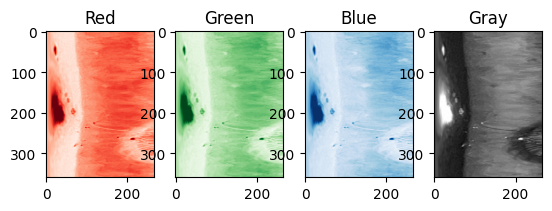

In [14]:
img_number = 13
TESTING_IMAGE_RGB = cls_1.test_processed_imgs['rgb'][img_number]
TESTING_IMAGE_GRAY = cls_1.test_processed_imgs['gray'][img_number]

b1 = TESTING_IMAGE_RGB[:,:,0] # get blue channel
g1 = TESTING_IMAGE_RGB[:,:,1] # get green channel
r1 = TESTING_IMAGE_RGB[:,:,2] # get red channel
gray = TESTING_IMAGE_GRAY[:,:] # get gray channel

fig, ax = plt.subplots(1,4)
ax[0].imshow(r1, cmap='Reds')
ax[1].imshow(g1, cmap='Greens')
ax[2].imshow(b1, cmap='Blues')
ax[3].imshow(gray, cmap='gray')
ax[0].title.set_text('Red')
ax[1].title.set_text('Green')
ax[2].title.set_text('Blue')
ax[3].title.set_text('Gray')

## Extraccion de Caracteristicas

In [31]:
cls_1.Xtrain = feature_process(cls_1.train_processed_imgs, cls_1.extracting_methods_pairs)

  0%|          | 0/1080 [00:00<?, ?it/s]

In [32]:
cls_1.Xtest = feature_process(cls_1.test_processed_imgs, cls_1.extracting_methods_pairs)

  0%|          | 0/360 [00:00<?, ?it/s]

In [30]:
cls_1.Xtrain.shape, cls_1.Xtest.shape

((1080, 2832), (360, 2832))

### Guardado de características

In [18]:
np.save('demo_1_features_train.npy', cls_1.Xtrain)

In [19]:
np.save('demo_1_features_test.npy', cls_1.Xtest)

## Entrenamiento modelo

In [42]:
cls_1.train(False)

Entrenando el modelo 90 con 1080 imagenes del set de train
Modelo LogisticRegression(C=2.1, solver='newton-cg') entrenado exitosamente


In [47]:
cls_1.model

LogisticRegression(C=2.1, solver='newton-cg')

### Guardado de modelo entrenado

In [49]:
f'{cls_1.model}_trained_model'

"LogisticRegression(C=2.1, solver='newton-cg')_trained_model"

In [50]:
saved_model_file_name = f'{cls_1.model}_trained_model'
cls_1.save_model(saved_model_file_name)

## Evaluacion del Modelo

In [48]:
cls_1.eval('test')

Evaluando el modelo LogisticRegression(C=2.1, solver='newton-cg') con 360 imagenes del set de test
Model evaluated!


0.8638888888888889

# Descarga de modelos entrenados



In [10]:
!gdown 1FY1pJRdsY-RYK47ggs2qaQ9RiFdXNuJg # Modelo entrenado

# Carga modelo entrenado
with open("LogisticRegression(C=2.1, solver='newton-cg')_trained_model", mode='rb') as trained_model_file:
    trained_model_1 = pickle.load(trained_model_file)

Downloading...
From: https://drive.google.com/uc?id=1FY1pJRdsY-RYK47ggs2qaQ9RiFdXNuJg
To: /content/LogisticRegression(C=2.1, solver='newton-cg')_trained_model
100% 2.04M/2.04M [00:00<00:00, 176MB/s]


In [11]:
trained_model_1

LogisticRegression(C=2.1, solver='newton-cg')

In [12]:
LBP_IS_RGB = True
cls = ModelWrapper(90, [(lbp, {'hdiv':4, 'vdiv':4}, LBP_IS_RGB)],  trained_model_1)

### Carga de características desde link de descarga y entrenamiento (opcional)
En esta sección puede entrenarse el modelo con los atributos extraidos para G00 y G01 y verificar el desempeño en el conjunto de entrenamiento y validación

In [13]:
!gdown 1DCyd8dbNnLnl3pM0v8uRJrltn6BtBYKV

cls.Xtrain = np.load('demo_1_features_train.npy')

Downloading...
From: https://drive.google.com/uc?id=1DCyd8dbNnLnl3pM0v8uRJrltn6BtBYKV
To: /content/demo_1_features_train.npy
100% 24.5M/24.5M [00:00<00:00, 149MB/s]


In [14]:
!gdown 1yD7BAHUXv6n4hEfAIhdKJ4w7ZuGd-Z4U

cls.y_train = np.load('demo_1_y_train.npy')

Downloading...
From: https://drive.google.com/uc?id=1yD7BAHUXv6n4hEfAIhdKJ4w7ZuGd-Z4U
To: /content/demo_1_y_train.npy
100% 8.77k/8.77k [00:00<00:00, 35.6MB/s]


In [21]:
!gdown 1oCTbuhixXcQdXGPp7TJKo2bTAJf46qep

cls.Xtest = np.load('demo_1_features_test.npy')

Downloading...
From: https://drive.google.com/uc?id=1oCTbuhixXcQdXGPp7TJKo2bTAJf46qep
To: /content/demo_1_features_test.npy
100% 8.16M/8.16M [00:00<00:00, 49.0MB/s]


In [22]:
!gdown 1ffkn2E26JrR2gA9gUpmN-hMLNs5mIVJU

cls.y_test = np.load('demo_1_y_test.npy')

Downloading...
From: https://drive.google.com/uc?id=1ffkn2E26JrR2gA9gUpmN-hMLNs5mIVJU
To: /content/demo_1_y_test.npy
100% 3.01k/3.01k [00:00<00:00, 16.6MB/s]


In [23]:
cls.Xtrain.shape, cls.Xtest.shape

((1080, 2832), (360, 2832))

In [24]:
# Entrenamiento

cls.train(False)

Entrenando el modelo 90 con 1080 imagenes del set de train
Modelo LogisticRegression(C=2.1, solver='newton-cg') entrenado exitosamente


In [25]:
# Evaluación

cls.eval('test')

Evaluando el modelo LogisticRegression(C=2.1, solver='newton-cg') con 360 imagenes del set de test
Model evaluated!


0.8638888888888889

### Testeo modelo entrenado
En esta sección se extraen las características de G02 para verificar el desempeño del modelo en el conjunto de testeo. Nótese que hay que reemplazar la URL de la primera celda por la correspondiente a G02.


In [26]:
test_dataset_name = download_dataset(TEST_URL_FOLDER) # Cambiar por imágenes de G02

Folder G01.zip.1 Downloaded!
Folder G01.zip.1 Unziped!


In [27]:
test_dataset_rgb, y_test = load_images(test_dataset_name, rgb=True)
test_dataset_gray, _     = load_images(test_dataset_name, rgb=False)

cls.y_test            = y_test
cls.test_dataset  = {'rgb' : test_dataset_rgb, 'gray' : test_dataset_gray}

Creating Dataset and Ground Truth
Loading 360 images to Dataset
Dataset filled with a total of 360 images
Creating Dataset and Ground Truth
Loading 360 images to Dataset
Dataset filled with a total of 360 images


In [28]:
test_processed_imgs_rgb  = imgs_process(cls.test_dataset['rgb'], rgb=True)
test_processed_imgs_gray = imgs_process(cls.test_dataset['gray'], rgb=False)

cls.test_processed_imgs  = {'rgb': test_processed_imgs_rgb, 'gray': test_processed_imgs_gray}

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

In [29]:
cls.Xtest = feature_process(cls.test_processed_imgs, cls.extracting_methods_pairs)

  0%|          | 0/360 [00:00<?, ?it/s]

In [31]:
cls.eval('test')

Evaluando el modelo LogisticRegression(C=2.1, solver='newton-cg') con 360 imagenes del set de test
Model evaluated!


0.8638888888888889